# Домашнее задание 8. GAN

Сдавать как обычно - Гитхаб или Гугл Колаб.

Задание - Обучите нейронную сеть любой архитектуры на каком-то производственном датасете. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.
Можно выполнить сегментацию по Северстали.

В конце, обязательно подвести вывод. Без этого минус балл.

Данная промежуточная аттестация оценивается по системе "зачет" / "не зачет"
Зачет" ставится, если слушатель успешно выполнил задание 1 или 2 задания
"Незачет"" ставится, если слушатель не выплнил 0 заданий

Критерии оценивания:
Слушатель обучите нейронную сеть и сделал анализ того, что вам помогло в улучшения работы нейронной сети
Слушатель сделал краткий обзор научной работы, посвящённой алгоритму нейронных сетей, не рассматриваемому ранее на курсе.


In [16]:
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(111)

Помимо библиотек, которые мы импортировали ранее, нам понадобится `torchvision` и `torchvision.transforms` для преобразования информации, хранящейся в файлах изображений.

Поскольку в этом примере обучающий набор включает изображения, модели будут сложнее, обучение будет происходить существенно дольше. При обучении на центральном процессоре ([CPU](https://ru.wikipedia.org/wiki/%D0%A6%D0%B5%D0%BD%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D0%BE%D1%80)) на одну эпоху будет уходить порядка двух минут. Для получения приемлемого результата понадобится порядка 50 эпох, поэтому общее время обучения при использовании процессора составляет около 100 минут.

Чтобы сократить время обучения, можно использовать графический процессор ([GPU](https://ru.wikipedia.org/wiki/%D0%93%D1%80%D0%B0%D1%84%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D0%BE%D1%80)).

Чтобы код работал независимо от характеристик компьютера, создадим объект `device`, который будет указывать либо на центральный процессор, либо (при наличии) на графический процессор:

In [17]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Окружение настроено, подготовим датасет для обучения.

# Подготовка датасета MNIST
Набор данных MNIST состоит из изображений написанных от руки цифр от 0 до 9. Изображения выполнены в градациях серого и имеют размер 28 × 28 пикселей. Чтобы использовать их с PyTorch, понадобится выполнить некоторые преобразования. Для этого определим функцию `transform`, используемую при загрузке данных:

In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Функция состоит из двух частей:

1. `transforms.ToTensor()` преобразует данные в тензор PyTorch.
2. `transforms.Normalize()` преобразует диапазон тензорных коэффициентов.

Исходные коэффициенты, заданные функцией `transforms.ToTensor()`, находятся в диапазоне от 0 до 1. Поскольку изображения имеют черный фон, большинство коэффициентов равны 0.

---

**Технические детали**. Аргументы `transforms.Normalize()` представляют собой это два кортежа `(M₁, ..., Mₙ)` и `(S₁, ..., Sₙ)`, где `n` соответствует количеству каналов в изображении. Картинки в градациях серого, как в наборе данных MNIST, имеют лишь один канал. Для каждого i-го канала изображения `transforms.Normalize()` вычитает `Mᵢ` из коэффициентов и делит результат на `Sᵢ`.

---

Функция `transforms.Normalize()` изменяет диапазон коэффициентов на $[-1, 1]$, вычитая 0.5 из исходных коэффициентов и деля результат на 0.5. Преобразование сокращает количество элементов входных выборок, равных 0. Это помогает в обучении моделей.

Теперь можно загрузить обучающие данные, вызвав `torchvision.datasets.MNIST`:

In [19]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 5181957.60it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 199232.08it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 1710467.30it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4549923.28it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



Аргумент `download = True` гарантирует, что при первом запуске кода набор данных MNIST будет загружен и сохранен в текущем каталоге, как указано в аргументе `root`.

Мы создали `train_set`, так что можно создать загрузчик данных, как делали это раньше:

In [20]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

Для избирательного построения данных воспользуемся matplotlib. В качестве палитры  хорошо подходит `cmap = gray_r`. Цифры будут изображаться черным цветом на белом фоне:

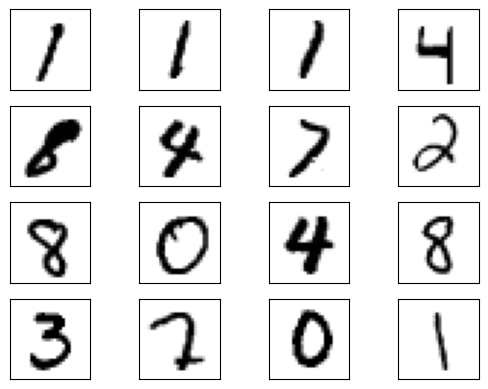

In [21]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

Вывод должен быть примерно таким:

![](https://files.realpython.com/media/fig_train_mnist_mpl.ddcdc8188b90.png)

Как видите, в датасете есть цифры с разными почерками. По мере того как GAN изучает распределение данных, она также генерирует цифры с разными стилями рукописного ввода.

Мы подготовили обучающие данные, можно реализовать модели дискриминатора и генератора.

# Реализация дискриминатора и генератора

В рассматриваемом случае дискриминатором является нейронная сеть многослойного перцептрона, которая принимает изображение размером 28 × 28 пикселей и находит вероятность того, что изображение принадлежит реальным обучающим данным.

Модель можно определить с помощью следующего кода:

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

Чтобы ввести коэффициенты изображения в нейронную сеть перцептрона, необходимо их векторизовать так, чтобы нейронная сеть получала вектор, состоящий из 784 коэффициентов (28 × 28 = 784).

Векторизация происходит в первой строке метода `forward()` – вызов `x.view()` преобразует форму входного тензора. Исходная форма тензора $x$ – `32 × 1 × 28 × 28`, где 32 – размер партии. После преобразования форма $x$ становится равной `32 × 784`, причем каждая строка представляет коэффициенты изображения обучающего набора.

Чтобы запустить модель дискриминатора с использованием графического процессора, нужно создать его экземпляр и связать с объектом устройства с помощью метода `.to()`:

In [23]:
discriminator = Discriminator().to(device=device)

Генератор будет создавать более сложные данные, чем в предыдущем примере. Поэтому необходимо увеличить размеры входных данных, используемых для инициализации. Здесь мы используем 100-мерный вход и выход с 784 коэффициентами. Результат организуется в виде тензора 28 × 28, представляющего изображение.

In [24]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

Выходные коэффициенты должны находиться в интервале от -1 до 1. Поэтому на выходе генератора мы используем гиперболическую функцию активации `Tanh()`. В последней строке мы создаем экземпляр генератора и связываем его с объектом устройства.

Осталось лишь обучить модели.

# Обучение моделей
Для обучения моделей нужно определить параметры обучения и оптимизаторы:

In [27]:
lr = 0.0001
num_epochs = 10
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Чтобы получить лучший результат, мы уменьшаем скорость обучения по сравнению с предыдущим примером. Чтобы сократить время обучения, устанавливаем количество эпох равным 50.

Цикл обучения похож на тот, что мы использовали в предыдущем примере:

In [28]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Данные для тренировки дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Показываем loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.43308770656585693
Epoch: 0 Loss G.: 1.3124172687530518
Epoch: 1 Loss D.: 0.47736841440200806
Epoch: 1 Loss G.: 1.1654106378555298
Epoch: 2 Loss D.: 0.40926462411880493
Epoch: 2 Loss G.: 1.2572757005691528
Epoch: 3 Loss D.: 0.501545786857605
Epoch: 3 Loss G.: 1.200248122215271
Epoch: 4 Loss D.: 0.39035359025001526
Epoch: 4 Loss G.: 1.1898537874221802
Epoch: 5 Loss D.: 0.45824533700942993
Epoch: 5 Loss G.: 1.1941109895706177
Epoch: 6 Loss D.: 0.5663173794746399
Epoch: 6 Loss G.: 1.1343884468078613
Epoch: 7 Loss D.: 0.4914848804473877
Epoch: 7 Loss G.: 1.3463048934936523
Epoch: 8 Loss D.: 0.49547651410102844
Epoch: 8 Loss G.: 1.2335379123687744
Epoch: 9 Loss D.: 0.4670988917350769
Epoch: 9 Loss G.: 1.198610544204712


# Проверка сгенерированных GAN образцов

Сгенерируем несколько образцов «рукописных цифр». Для этого передадим генератору инициирующий набор случайных чисел:

In [29]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

Чтобы построить сгенерированные выборки, нужно переместить данные обратно в центральный процессор, если их обработка происходила на графическом процессоре. Для этого достаточно вызвать метод `cpu()`. Как и раньше, перед  построением данных необходимо вызвать `.detach()`:

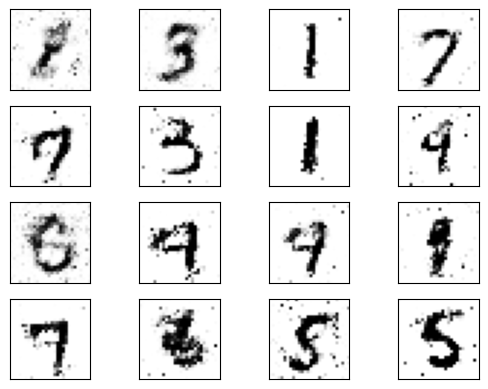

In [30]:
generated_samples = generated_samples.cpu().detach()

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

На выходе должны получиться цифры, напоминающие обучющие данные.

![](https://files.realpython.com/media/fig_generated_mnist_mpl.ecc483e9dd9d.png)

После пятидесяти эпох обучения есть несколько цифр, которые как будто писала рука человека. Результаты можно улучшить, проводя более длительное обучение (с бо́льшим количеством эпох). Как и в предыдущем примере, можно визуализировать эволюцию обучения, используя фиксированный тензор входных данных и подавая его на генератор в конце каждой эпохи:

![](https://files.realpython.com/media/fig_gan_mnist.5d8784a85944.gif)

В начале процесса обучения сгенерированные изображения абсолютно случайны. По мере обучения генератор изучает распределение реальных данных, и примерно через двадцать эпох некоторые сгенерированные изображения цифр уже напоминают реальные данные.

# Вывод:
 

   #### На данном примере взятом с [GitHub](https://github.com/matyushkin/lessons/blob/master/neural_networks/GAN_intro.ipynb) на реальном примере видно как обучается и работает, генеративная состязательная сеть (GAN). Модель нейронной сети построена на PyTorch.
  #### Улучшить результат генерации рукописных цифр можно увеличивая количество эпох, при обучении НС.Но это приведёт к увеличению времени расчёта.
  #### Подобрав оптимальный размер пакета (batch size) мы оптимизируем использование памяти и ускоряем процесс обучения. Больший размер пакета позволяет параллельно обрабатывать больше примеров данных, ускоряя процесс обучени, однако этот процесс может потреблять больше памяти и ресурсов. 
   #### Оптимизатор Adam был выбран для обучения моделей, так как он обладает преимуществами перед другими оптимизаторами, такими как SGD (Stochastic Gradient Descent) или RMSprop. Adam обычно демонстрирует более быструю сходимость и обучает модели более стабильно.
  ####  Функция потерь BCELoss была выбрана, потому что она часто используется в задачах бинарной классификации, которая часто встречается в генеративно-состязательных сетях (GAN). Она хорошо подходит для оценки ошибки в сети, где нужно предсказать вероятность принадлежности к двум классам.
   #### При создании дискриминатора примеенены нескольких слоев с увеличивающимися размерами узлов позволяет модели изучать сложные зависимости между данными. Это помогает дискриминатору лучше различать реальные данные от сгенерированных. А Dropout слои помогают снизить переобучение модели путем случайного "выключения" части нейронов во время обучения.

